### DCGAN

Ссылка на исходный код https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [130]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from matplotlib import pyplot

### Загрузка и подготовка датасета

In [131]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [132]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

In [133]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [134]:
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [135]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [136]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [137]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


In [138]:
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    # filename = 'generated_plot_e%03d.png' % (epoch+1)
    # pyplot.savefig(filename)
    pyplot.show()

In [139]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model.h5'
    g_model.save(filename)

In [140]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            if j % 100 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/195, d1=0.687, d2=0.696 g=0.614
>1, 101/195, d1=0.000, d2=0.000 g=0.226
>Accuracy real: 91%, fake: 99%


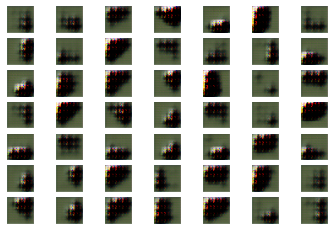

>2, 1/195, d1=0.131, d2=0.066 g=0.000
>2, 101/195, d1=0.728, d2=0.288 g=2.321
>Accuracy real: 99%, fake: 100%


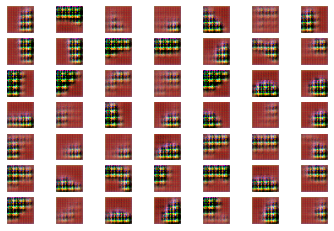

>3, 1/195, d1=0.095, d2=0.023 g=0.011
>3, 101/195, d1=0.089, d2=0.030 g=0.032
>Accuracy real: 99%, fake: 100%


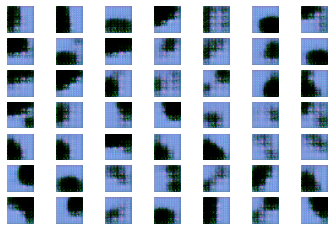

>4, 1/195, d1=0.077, d2=0.010 g=0.000
>4, 101/195, d1=0.064, d2=0.014 g=0.002
>Accuracy real: 99%, fake: 100%


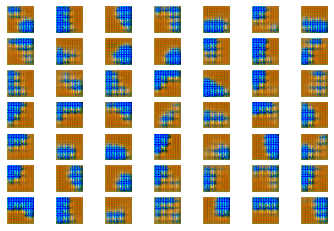

>5, 1/195, d1=0.008, d2=0.004 g=0.010
>5, 101/195, d1=0.089, d2=0.016 g=0.137
>Accuracy real: 99%, fake: 99%


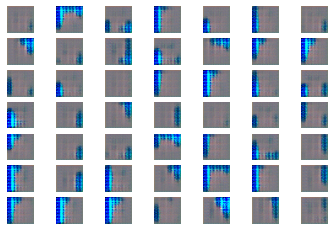

>6, 1/195, d1=0.001, d2=0.068 g=0.002
>6, 101/195, d1=0.129, d2=0.130 g=1.251
>Accuracy real: 99%, fake: 100%


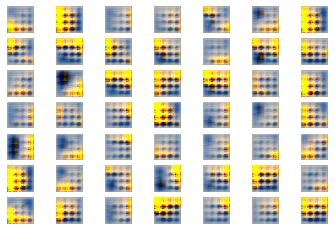

>7, 1/195, d1=0.012, d2=0.022 g=0.017
>7, 101/195, d1=0.084, d2=0.167 g=0.318
>Accuracy real: 97%, fake: 100%


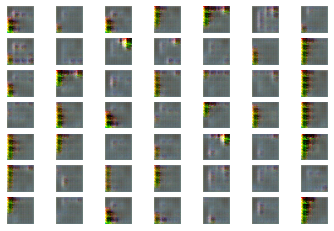

>8, 1/195, d1=0.096, d2=0.029 g=0.011
>8, 101/195, d1=0.067, d2=0.025 g=0.004
>Accuracy real: 97%, fake: 100%


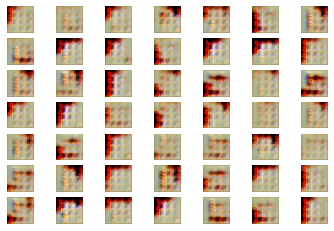

>9, 1/195, d1=0.103, d2=0.028 g=0.006
>9, 101/195, d1=0.018, d2=0.013 g=0.007
>Accuracy real: 99%, fake: 100%


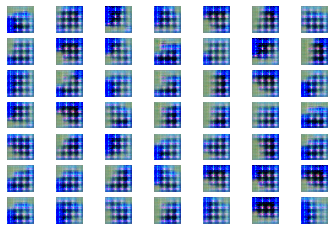

>10, 1/195, d1=0.003, d2=0.010 g=0.001
>10, 101/195, d1=0.128, d2=0.064 g=0.001
>Accuracy real: 97%, fake: 100%


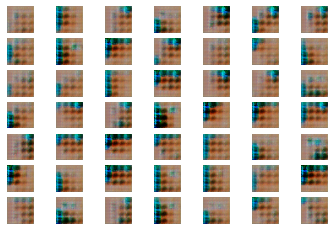

>11, 1/195, d1=0.053, d2=0.016 g=0.010
>11, 101/195, d1=0.004, d2=0.005 g=0.034
>Accuracy real: 99%, fake: 100%


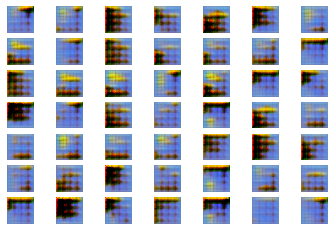

>12, 1/195, d1=0.048, d2=0.039 g=0.019
>12, 101/195, d1=0.013, d2=0.009 g=0.001
>Accuracy real: 100%, fake: 100%


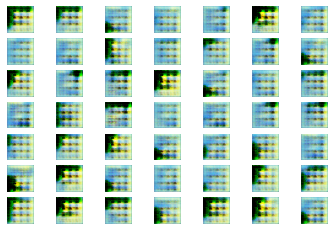

>13, 1/195, d1=0.001, d2=0.005 g=0.004
>13, 101/195, d1=0.003, d2=0.007 g=0.000
>Accuracy real: 99%, fake: 100%


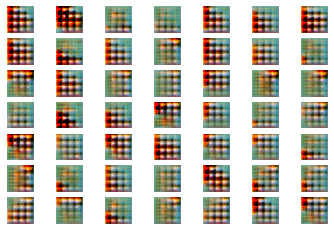

>14, 1/195, d1=0.011, d2=0.017 g=0.005
>14, 101/195, d1=0.062, d2=0.065 g=0.085
>Accuracy real: 99%, fake: 100%


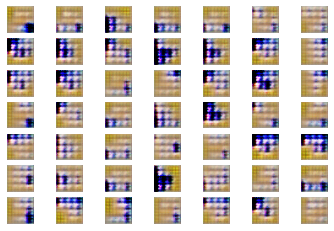

>15, 1/195, d1=0.014, d2=0.030 g=0.007
>15, 101/195, d1=0.024, d2=0.024 g=0.014
>Accuracy real: 99%, fake: 100%


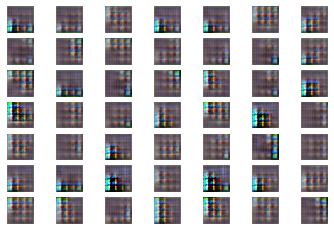

>16, 1/195, d1=0.041, d2=0.026 g=0.021
>16, 101/195, d1=0.008, d2=0.008 g=0.014
>Accuracy real: 100%, fake: 100%


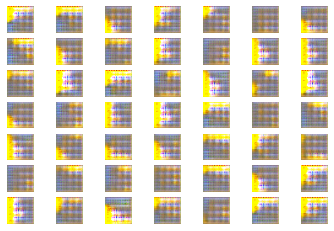

>17, 1/195, d1=0.063, d2=0.019 g=0.013
>17, 101/195, d1=0.007, d2=0.012 g=0.050
>Accuracy real: 95%, fake: 100%


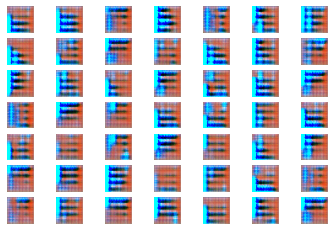

>18, 1/195, d1=0.122, d2=0.003 g=0.000
>18, 101/195, d1=0.015, d2=0.000 g=0.000
>Accuracy real: 95%, fake: 99%


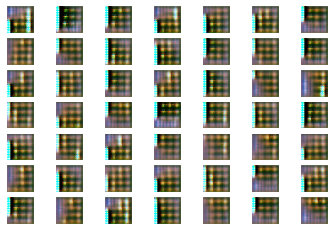

>19, 1/195, d1=0.223, d2=0.103 g=0.002
>19, 101/195, d1=0.075, d2=0.062 g=0.039
>Accuracy real: 100%, fake: 100%


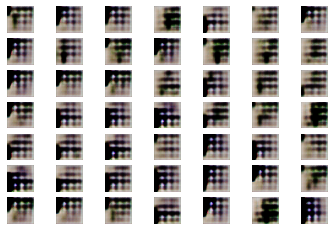

>20, 1/195, d1=0.015, d2=0.005 g=0.001
>20, 101/195, d1=0.014, d2=0.019 g=0.002
>Accuracy real: 98%, fake: 100%


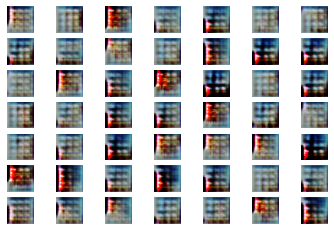

>21, 1/195, d1=0.070, d2=0.124 g=0.813
>21, 101/195, d1=0.335, d2=0.181 g=0.391
>Accuracy real: 100%, fake: 100%


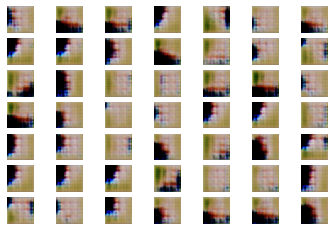

>22, 1/195, d1=0.006, d2=0.013 g=0.020
>22, 101/195, d1=0.066, d2=0.061 g=0.069
>Accuracy real: 99%, fake: 100%


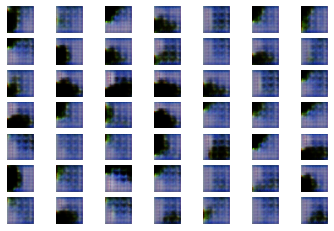

>23, 1/195, d1=0.040, d2=0.020 g=0.010
>23, 101/195, d1=0.013, d2=0.002 g=0.009
>Accuracy real: 100%, fake: 100%


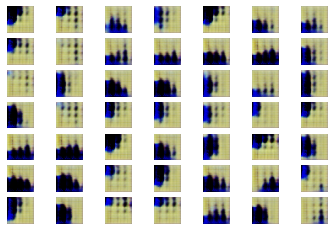

>24, 1/195, d1=0.001, d2=0.002 g=0.001
>24, 101/195, d1=0.000, d2=0.002 g=0.005
>Accuracy real: 99%, fake: 100%


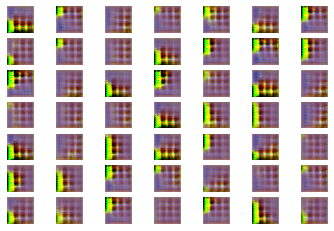

>25, 1/195, d1=0.008, d2=0.019 g=0.000
>25, 101/195, d1=0.054, d2=0.005 g=0.005
>Accuracy real: 100%, fake: 100%


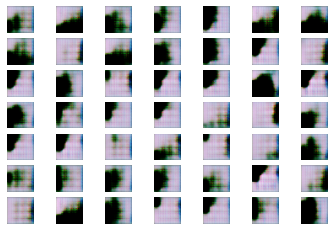

>26, 1/195, d1=0.056, d2=0.053 g=0.038
>26, 101/195, d1=0.007, d2=0.012 g=0.007
>Accuracy real: 99%, fake: 100%


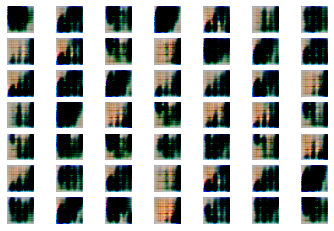

>27, 1/195, d1=0.053, d2=0.019 g=0.015
>27, 101/195, d1=0.012, d2=0.008 g=0.113
>Accuracy real: 99%, fake: 100%


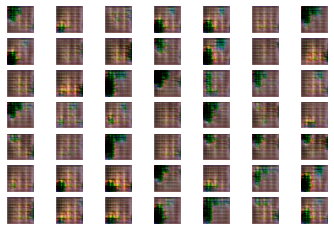

>28, 1/195, d1=0.026, d2=0.018 g=0.012
>28, 101/195, d1=0.013, d2=0.005 g=0.001
>Accuracy real: 100%, fake: 100%


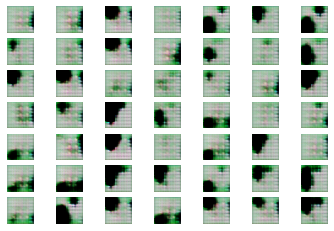

>29, 1/195, d1=0.003, d2=0.005 g=0.004
>29, 101/195, d1=0.004, d2=0.003 g=0.002
>Accuracy real: 100%, fake: 100%


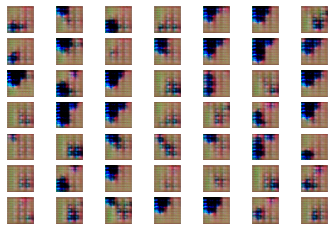

>30, 1/195, d1=0.034, d2=0.014 g=0.003
>30, 101/195, d1=0.023, d2=0.006 g=0.067
>Accuracy real: 95%, fake: 100%


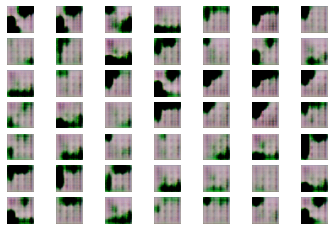

>31, 1/195, d1=0.091, d2=0.049 g=0.015
>31, 101/195, d1=0.014, d2=0.024 g=0.018
>Accuracy real: 100%, fake: 100%


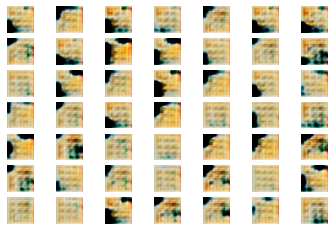

>32, 1/195, d1=0.036, d2=0.010 g=0.148
>32, 101/195, d1=0.010, d2=0.015 g=0.011
>Accuracy real: 100%, fake: 100%


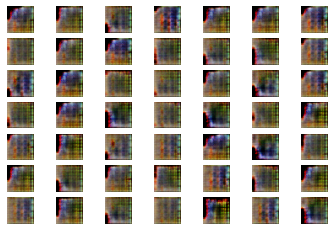

>33, 1/195, d1=0.007, d2=0.010 g=0.000
>33, 101/195, d1=0.003, d2=0.014 g=0.104
>Accuracy real: 100%, fake: 100%


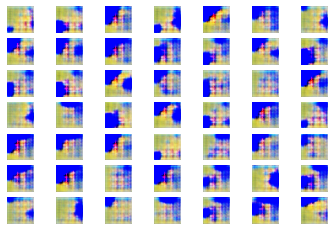

>34, 1/195, d1=0.000, d2=0.003 g=0.000
>34, 101/195, d1=0.000, d2=0.002 g=0.008
>Accuracy real: 99%, fake: 100%


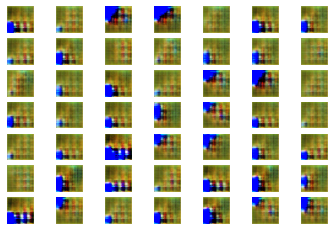

>35, 1/195, d1=0.044, d2=0.001 g=0.007
>35, 101/195, d1=0.002, d2=0.002 g=0.006
>Accuracy real: 97%, fake: 100%


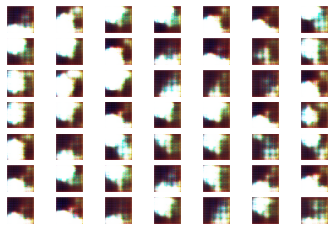

>36, 1/195, d1=0.051, d2=0.102 g=0.030
>36, 101/195, d1=0.093, d2=0.020 g=0.006
>Accuracy real: 99%, fake: 99%


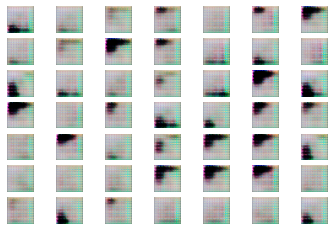

>37, 1/195, d1=0.006, d2=0.009 g=0.212
>37, 101/195, d1=0.001, d2=0.012 g=0.002
>Accuracy real: 88%, fake: 100%


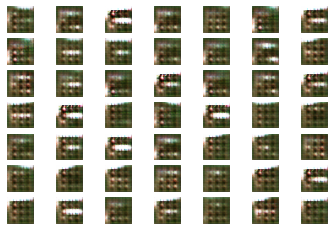

>38, 1/195, d1=0.291, d2=0.137 g=1.181
>38, 101/195, d1=0.014, d2=0.017 g=0.020
>Accuracy real: 99%, fake: 100%


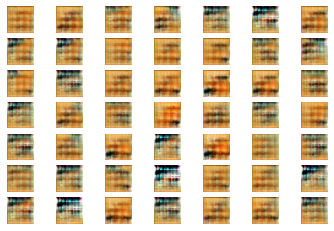

>39, 1/195, d1=0.061, d2=0.010 g=0.020
>39, 101/195, d1=0.197, d2=0.041 g=1.245
>Accuracy real: 99%, fake: 100%


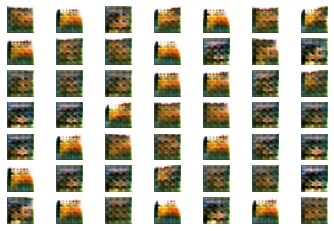

>40, 1/195, d1=0.019, d2=0.010 g=0.006
>40, 101/195, d1=0.054, d2=0.025 g=0.004
>Accuracy real: 100%, fake: 100%


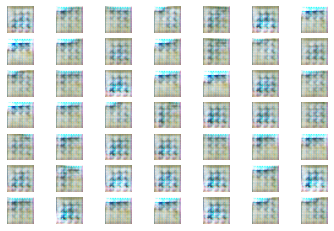

>41, 1/195, d1=0.003, d2=0.004 g=0.008
>41, 101/195, d1=0.030, d2=0.033 g=0.181
>Accuracy real: 99%, fake: 100%


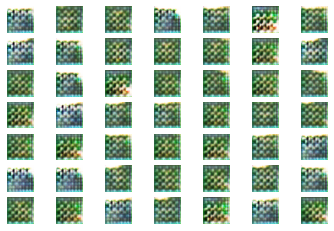

>42, 1/195, d1=0.001, d2=0.004 g=0.017
>42, 101/195, d1=0.070, d2=0.021 g=0.013
>Accuracy real: 99%, fake: 100%


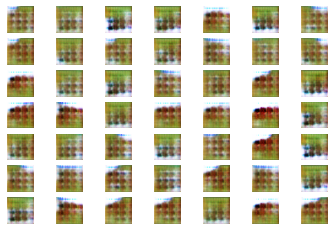

>43, 1/195, d1=0.004, d2=0.017 g=0.036
>43, 101/195, d1=0.020, d2=0.017 g=0.410
>Accuracy real: 100%, fake: 100%


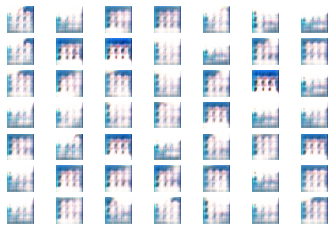

>44, 1/195, d1=0.001, d2=0.006 g=0.046
>44, 101/195, d1=0.007, d2=0.009 g=0.015
>Accuracy real: 99%, fake: 100%


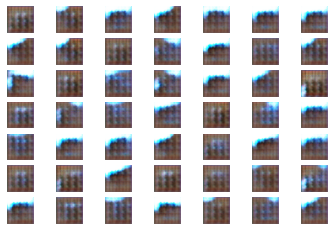

>45, 1/195, d1=0.006, d2=0.008 g=0.127
>45, 101/195, d1=0.000, d2=0.001 g=0.007
>Accuracy real: 100%, fake: 100%


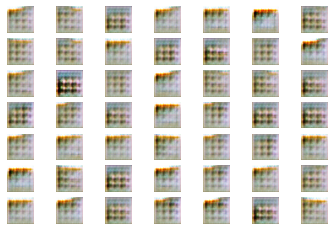

>46, 1/195, d1=0.001, d2=0.007 g=0.023
>46, 101/195, d1=0.000, d2=0.002 g=0.028
>Accuracy real: 99%, fake: 100%


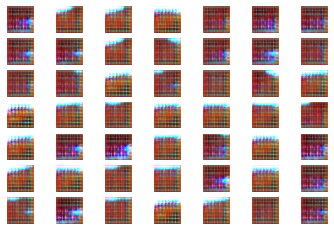

>47, 1/195, d1=0.009, d2=0.015 g=0.125
>47, 101/195, d1=0.167, d2=0.001 g=0.131
>Accuracy real: 100%, fake: 100%


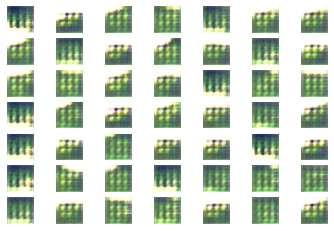

>48, 1/195, d1=0.051, d2=0.012 g=0.011
>48, 101/195, d1=0.083, d2=0.012 g=0.076
>Accuracy real: 100%, fake: 100%


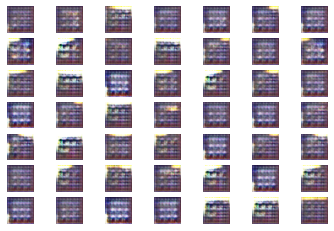

>49, 1/195, d1=0.006, d2=0.014 g=0.017
>49, 101/195, d1=0.004, d2=0.009 g=0.007
>Accuracy real: 97%, fake: 100%


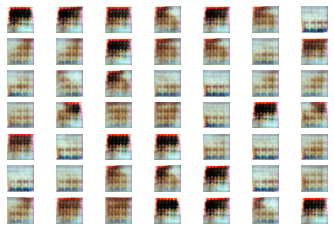

>50, 1/195, d1=0.115, d2=0.085 g=0.254
>50, 101/195, d1=0.212, d2=0.229 g=2.124
>Accuracy real: 100%, fake: 100%


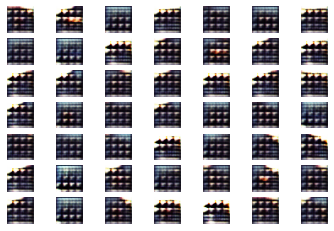

In [141]:
latent_dim = 100
# создание дискриминатора
d_model = define_discriminator()
# создание генератора
g_model = define_generator(latent_dim)
# Создание GAN
gan_model = define_gan(g_model, d_model)
# загрузка изображения
dataset = load_real_samples()
# тренировка модели
train(g_model, d_model, gan_model, dataset, latent_dim, 50, 256)